In [1]:
from data_fns import load_mnist
from estimator import RFClassifier, classical_weights, V1_weights_multiple_scales, relu, parallelized_clf
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pickle

In [2]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)
client

Client Scheduler: tcp://127.0.0.1:38919 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 25 Memory: 135.06 GB


In [37]:
# load data
X_train, y_train, X_test, y_test = load_mnist('data/mnist')

In [38]:
n_features = sorted(set(np.logspace(0, 3.3, 100).astype('int')))

# weight params
scale = 1/2
kwargs = {'scale': scale}
weights_V1 = {'weight_fun': V1_weights_multiple_scales, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights, 'kwargs': kwargs}

# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X_train.shape[0]))

In [ ]:
n_features = sorted(set(np.logspace(0, 3.3, 50).astype('int')))


# weight params

kwargs = {'scale': scale}
weights_V1 = {'weight_fun': V1_weights_multiple_scales, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights, 'kwargs': kwargs}

# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X_train.shape[0]))

# %%time
results = {}
m = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
results['V1'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                    params_classical, 
                                                                                                    X_train, y_train, 
                                                                                                    X_test, y_test, 
                                                                                                    n_iters=3)

    # haltere inspired
    params_V1 = {'width': n, **weights_V1, 'bias': b, 'nonlinearity': relu, 'clf': sgd} 
    _, _, results['V1']['avg_test_err'][i], results['V1']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                params_V1, 
                                                                                                X_train, y_train, 
                                                                                                X_test, y_test, 
                                                                                                n_iters=5)

    print('Iter: %d/%d, V1 test err: %0.2f, RF test err: %0.2f' % (i, len(n_features),
                                                                   results['V1']['avg_test_err'][i],
                                                                  results['classical']['avg_test_err'][i]))

with open('results/mnist_clf/mnist_clf_multiscale_scale=%0.5f.pickle' % scale, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

Sca;e: 0.50000, Iter: 0/43, V1 test err: 0.89, RF test err: 0.89
Sca;e: 0.50000, Iter: 1/43, V1 test err: 0.85, RF test err: 0.86
Sca;e: 0.50000, Iter: 2/43, V1 test err: 0.86, RF test err: 0.85
Sca;e: 0.50000, Iter: 3/43, V1 test err: 0.71, RF test err: 0.80
Sca;e: 0.50000, Iter: 4/43, V1 test err: 0.73, RF test err: 0.76
Sca;e: 0.50000, Iter: 5/43, V1 test err: 0.69, RF test err: 0.77
Sca;e: 0.50000, Iter: 6/43, V1 test err: 0.68, RF test err: 0.78
Sca;e: 0.50000, Iter: 7/43, V1 test err: 0.65, RF test err: 0.71
Sca;e: 0.50000, Iter: 8/43, V1 test err: 0.58, RF test err: 0.70
Sca;e: 0.50000, Iter: 9/43, V1 test err: 0.63, RF test err: 0.69
Sca;e: 0.50000, Iter: 10/43, V1 test err: 0.53, RF test err: 0.61
Sca;e: 0.50000, Iter: 11/43, V1 test err: 0.46, RF test err: 0.55
Sca;e: 0.50000, Iter: 12/43, V1 test err: 0.43, RF test err: 0.55
Sca;e: 0.50000, Iter: 13/43, V1 test err: 0.42, RF test err: 0.54
Sca;e: 0.50000, Iter: 14/43, V1 test err: 0.40, RF test err: 0.56
Sca;e: 0.50000, Iter

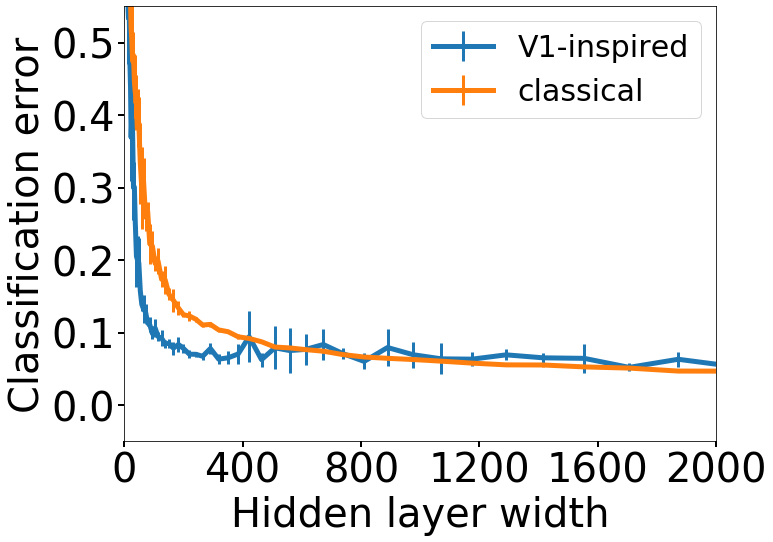

In [18]:
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['V1']['avg_test_err'], yerr=results['V1']['std_test_err'], fmt='-', 
            label='V1-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xticks(np.arange(0, 1020, 200))
plt.xlim([0, 2000])
plt.yticks(np.arange(0, 0.6, 0.1))
plt.ylim([-0.05, 0.55])
plt.xticks(np.arange(0, 2200, 400))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)

plt.legend(loc = 'upper right', fontsize=30)

In [19]:
list(zip(n_features, results['classical']['avg_test_err']))

[(1, 0.897),
 (2, 0.86678),
 (3, 0.83162),
 (4, 0.80244),
 (5, 0.80128),
 (6, 0.76008),
 (7, 0.75522),
 (8, 0.71226),
 (9, 0.69576),
 (10, 0.6977599999999999),
 (11, 0.6612199999999999),
 (12, 0.65062),
 (13, 0.62522),
 (14, 0.6178199999999999),
 (16, 0.5963399999999999),
 (17, 0.57538),
 (19, 0.5661400000000001),
 (21, 0.5546800000000001),
 (23, 0.5204000000000001),
 (25, 0.50644),
 (28, 0.47462),
 (31, 0.4827),
 (34, 0.44636),
 (37, 0.43111999999999995),
 (41, 0.42626),
 (45, 0.3961200000000001),
 (49, 0.388),
 (54, 0.3336),
 (59, 0.29954000000000003),
 (65, 0.30926),
 (72, 0.25911999999999996),
 (79, 0.26714000000000004),
 (86, 0.22244000000000003),
 (95, 0.2192),
 (104, 0.19536),
 (114, 0.19892),
 (126, 0.17358),
 (138, 0.17294),
 (151, 0.15272000000000002),
 (166, 0.14452000000000004),
 (183, 0.13382),
 (200, 0.1246),
 (220, 0.12294000000000001),
 (242, 0.11836000000000002),
 (265, 0.11043999999999998),
 (291, 0.11127999999999998),
 (319, 0.10368),
 (351, 0.10117999999999998),
 (3

In [20]:
list(zip(n_features, results['V1']['avg_test_err']))

[(1, 0.86948),
 (2, 0.7824),
 (3, 0.7823800000000001),
 (4, 0.7762600000000001),
 (5, 0.7885),
 (6, 0.7264199999999998),
 (7, 0.6972),
 (8, 0.67158),
 (9, 0.61536),
 (10, 0.60392),
 (11, 0.5940399999999999),
 (12, 0.5691600000000001),
 (13, 0.54392),
 (14, 0.53366),
 (16, 0.53728),
 (17, 0.53152),
 (19, 0.47059999999999996),
 (21, 0.43792),
 (23, 0.36922000000000005),
 (25, 0.39482),
 (28, 0.37598000000000004),
 (31, 0.30016),
 (34, 0.30080000000000007),
 (37, 0.25234),
 (41, 0.20518),
 (45, 0.1995),
 (49, 0.19622),
 (54, 0.15748),
 (59, 0.13906),
 (65, 0.1324),
 (72, 0.12811999999999998),
 (79, 0.11298),
 (86, 0.11094),
 (95, 0.09856000000000001),
 (104, 0.10644),
 (114, 0.09457999999999997),
 (126, 0.09215999999999999),
 (138, 0.08466000000000003),
 (151, 0.08509999999999998),
 (166, 0.07850000000000004),
 (183, 0.08366000000000003),
 (200, 0.07805999999999998),
 (220, 0.07015999999999997),
 (242, 0.07002),
 (265, 0.06732),
 (291, 0.07801999999999998),
 (319, 0.06334000000000002),
 (

### Few shot learning

In [23]:
train, train_labels, test, test_labels = load_mnist('data/mnist')
num_train = 50
X_train, _, y_train, _ = train_test_split(train, train_labels, train_size=num_train, stratify=train_labels, 
                                          random_state=42)
X_test, y_test = test.copy(), test_labels.copy()

In [24]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))

# weight params
scale = 1
kwargs = {'scale': scale}
weights_V1 = {'weight_fun': V1_weights_multiple_scales, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights, 'kwargs': kwargs}


# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.2, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X_train.shape[0]))

In [25]:
%%time
results = {}
m = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
results['V1'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                    params_classical, 
                                                                                                    X_train, y_train, 
                                                                                                    X_test, y_test, 
                                                                                                    n_iters=5)
    
    # haltere inspired
    params_V1 = {'width': n, **weights_V1, 'bias': b, 'nonlinearity': relu, 'clf': sgd} 
    _, _, results['V1']['avg_test_err'][i], results['V1']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                params_V1, 
                                                                                                X_train, y_train, 
                                                                                                X_test, y_test, 
                                                                                                n_iters=5)

    print('Iter: %d/%d' % (i, len(n_features)))
    
with open('results/mnist_clf/mnist_clf_multiscale_scale=%0.2f_fewshot.pickle' % scale, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

Iter: 0/42
Iter: 1/42
Iter: 2/42
Iter: 3/42
Iter: 4/42
Iter: 5/42
Iter: 6/42
Iter: 7/42
Iter: 8/42
Iter: 9/42
Iter: 10/42
Iter: 11/42
Iter: 12/42
Iter: 13/42
Iter: 14/42
Iter: 15/42
Iter: 16/42
Iter: 17/42
Iter: 18/42
Iter: 19/42
Iter: 20/42
Iter: 21/42
Iter: 22/42
Iter: 23/42
Iter: 24/42
Iter: 25/42
Iter: 26/42
Iter: 27/42
Iter: 28/42
Iter: 29/42
Iter: 30/42
Iter: 31/42
Iter: 32/42
Iter: 33/42
Iter: 34/42
Iter: 35/42
Iter: 36/42
Iter: 37/42
Iter: 38/42
Iter: 39/42
Iter: 40/42
Iter: 41/42
CPU times: user 1min 25s, sys: 1min 17s, total: 2min 42s
Wall time: 13min 2s


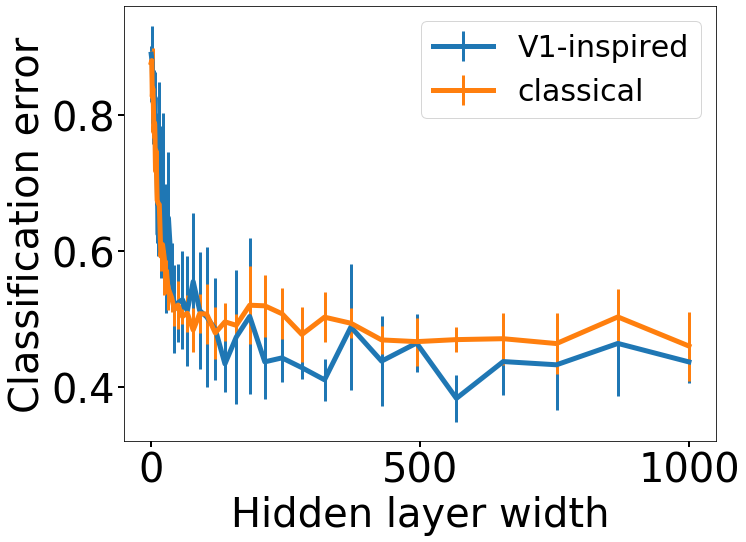

In [26]:
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['V1']['avg_test_err'], yerr=results['V1']['std_test_err'], fmt='-', 
            label='V1-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
# plt.xticks(np.arange(0, 1020, 200))
# plt.xlim([0, 1000])
# plt.yticks(np.arange(0, 0.6, 0.1))
# plt.ylim([-0.05, 0.55])
# plt.xticks(np.arange(0, 255, 50))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)

plt.legend(loc = 'upper right', fontsize=30)

In [27]:
list(zip(n_features, results['V1']['avg_test_err']))

[(1, 0.8902199999999999),
 (2, 0.88344),
 (3, 0.8786400000000001),
 (4, 0.82006),
 (5, 0.8446199999999999),
 (6, 0.78718),
 (7, 0.7954),
 (8, 0.82652),
 (9, 0.75346),
 (10, 0.7332400000000001),
 (12, 0.7075600000000002),
 (14, 0.62422),
 (16, 0.75682),
 (19, 0.6727),
 (22, 0.6901599999999999),
 (25, 0.618),
 (29, 0.60424),
 (33, 0.6490199999999999),
 (39, 0.5681200000000001),
 (44, 0.51438),
 (51, 0.5241199999999999),
 (59, 0.5285400000000001),
 (68, 0.5118400000000001),
 (79, 0.55522),
 (91, 0.51258),
 (104, 0.5031800000000001),
 (120, 0.48508000000000007),
 (138, 0.43389999999999995),
 (159, 0.47338),
 (184, 0.5037999999999999),
 (212, 0.4369199999999999),
 (244, 0.44273999999999997),
 (281, 0.42829999999999996),
 (323, 0.41044),
 (372, 0.48824000000000006),
 (429, 0.4379799999999999),
 (494, 0.46456),
 (568, 0.38308),
 (655, 0.43732),
 (754, 0.43255999999999994),
 (868, 0.46403999999999995),
 (1000, 0.43678)]

In [28]:
list(zip(n_features, results['classical']['avg_test_err']))

[(1, 0.8779199999999999),
 (2, 0.88088),
 (3, 0.82774),
 (4, 0.8398),
 (5, 0.81608),
 (6, 0.77506),
 (7, 0.7891400000000001),
 (8, 0.7673),
 (9, 0.71824),
 (10, 0.74796),
 (12, 0.67516),
 (14, 0.67034),
 (16, 0.6686400000000001),
 (19, 0.5926800000000001),
 (22, 0.60982),
 (25, 0.5916399999999999),
 (29, 0.5624),
 (33, 0.54408),
 (39, 0.53142),
 (44, 0.514),
 (51, 0.5206200000000001),
 (59, 0.50366),
 (68, 0.50862),
 (79, 0.4838),
 (91, 0.5078799999999999),
 (104, 0.5073399999999999),
 (120, 0.47952000000000006),
 (138, 0.49588),
 (159, 0.49074),
 (184, 0.5203599999999999),
 (212, 0.5194799999999999),
 (244, 0.5078),
 (281, 0.4772600000000001),
 (323, 0.50274),
 (372, 0.49378),
 (429, 0.46921999999999997),
 (494, 0.4667),
 (568, 0.46966),
 (655, 0.471),
 (754, 0.46384),
 (868, 0.5031000000000001),
 (1000, 0.46018)]